In [60]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [48]:
class HandGestureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [49]:
class HandGestureModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(HandGestureModel, self).__init__()
        self.model = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(input_size, 20),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [50]:
def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data['data'], data['labels']

In [51]:
def convert_labels(labels):
    unique_labels = list(set(labels))
    label_to_id = {label: i for i, label in enumerate(unique_labels)}
    return [label_to_id[label] for label in labels], label_to_id

In [52]:
class EarlyStopping:
    def __init__(self, patience=20, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [53]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_save_path):
    early_stopping = EarlyStopping(patience=20, verbose=True, path=model_save_path)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for features, labels in val_loader:
                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_accuracy = correct / total
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {total_loss/len(train_loader):.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Accuracy: {val_accuracy:.4f}')
        
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

In [54]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_loss /= len(test_loader)
    test_accuracy = correct / total
    return test_loss, test_accuracy

In [55]:
def generate_confusion_matrix(model, test_loader, device, class_names):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a dataframe for the confusion matrix
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # Print classification report
    print('Classification Report')
    print(classification_report(y_true, y_pred, target_names=class_names))

In [56]:
features, labels = load_data('data.pickle')

# Convert string labels to numeric
numeric_labels, label_to_id = convert_labels(labels)

# Create dataset
dataset = HandGestureDataset(features, numeric_labels)

In [57]:
# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

In [58]:
# Initialize model
input_size = len(features[0])  # Number of features (42 for 21 landmarks with x and y)
num_classes = len(label_to_id)
model = HandGestureModel(input_size, num_classes)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Set model save path
model_save_path = 'hand_gesture_model.pth'

# Train the model
num_epochs = 1000
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_save_path)

# Load the best model
model.load_state_dict(torch.load(model_save_path))

# Evaluate the model
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Save the label_to_id mapping for future use
with open('label_mapping.pickle', 'wb') as f:
    pickle.dump(label_to_id, f)

print("Training and evaluation completed. Label mapping saved.")

Epoch [1/1000], Train Loss: 2.3941, Val Loss: 2.3643, Val Accuracy: 0.0980
Validation loss decreased (inf --> 2.364301). Saving model ...
Epoch [2/1000], Train Loss: 2.3892, Val Loss: 2.3621, Val Accuracy: 0.0980
Validation loss decreased (2.364301 --> 2.362098). Saving model ...
Epoch [3/1000], Train Loss: 2.3895, Val Loss: 2.3591, Val Accuracy: 0.0980
Validation loss decreased (2.362098 --> 2.359086). Saving model ...
Epoch [4/1000], Train Loss: 2.3832, Val Loss: 2.3553, Val Accuracy: 0.0980
Validation loss decreased (2.359086 --> 2.355267). Saving model ...
Epoch [5/1000], Train Loss: 2.3823, Val Loss: 2.3504, Val Accuracy: 0.0980
Validation loss decreased (2.355267 --> 2.350371). Saving model ...
Epoch [6/1000], Train Loss: 2.3791, Val Loss: 2.3466, Val Accuracy: 0.1503
Validation loss decreased (2.350371 --> 2.346616). Saving model ...
Epoch [7/1000], Train Loss: 2.3729, Val Loss: 2.3432, Val Accuracy: 0.1830
Validation loss decreased (2.346616 --> 2.343163). Saving model ...
Epoc

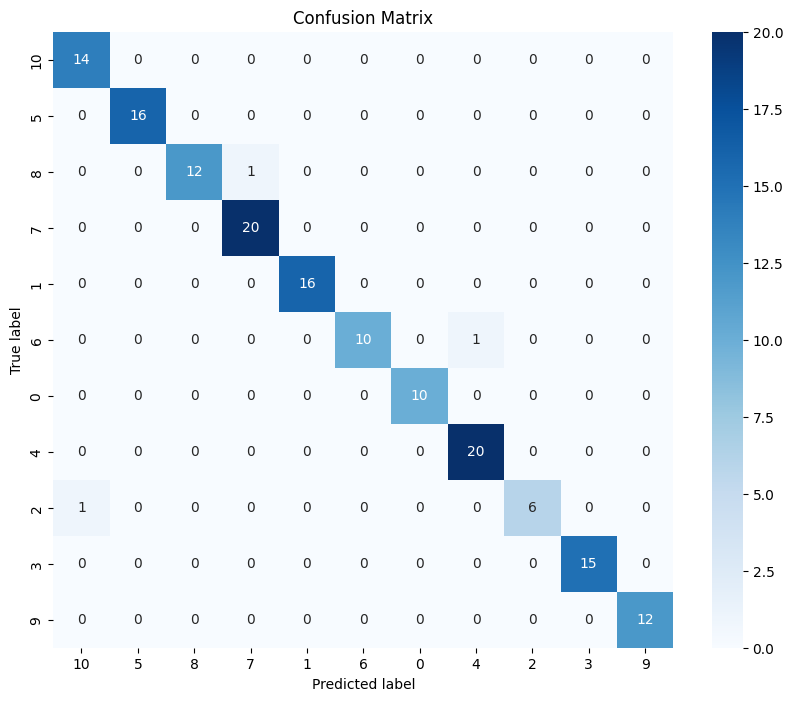

Classification Report
              precision    recall  f1-score   support

          10       0.93      1.00      0.97        14
           5       1.00      1.00      1.00        16
           8       1.00      0.92      0.96        13
           7       0.95      1.00      0.98        20
           1       1.00      1.00      1.00        16
           6       1.00      0.91      0.95        11
           0       1.00      1.00      1.00        10
           4       0.95      1.00      0.98        20
           2       1.00      0.86      0.92         7
           3       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        12

    accuracy                           0.98       154
   macro avg       0.99      0.97      0.98       154
weighted avg       0.98      0.98      0.98       154



In [61]:
# Get the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model = model.to(device)

# Get class names
with open('label_mapping.pickle', 'rb') as f:
    label_to_id = pickle.load(f)
class_names = [k for k, v in sorted(label_to_id.items(), key=lambda item: item[1])]

# Generate and display confusion matrix and classification report
generate_confusion_matrix(model, test_loader, device, class_names)

In [2]:
import torch
import torch.nn as nn
import torch.utils.mobile_optimizer as mobile_optimizer

class HandGestureModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(HandGestureModel, self).__init__()
        self.model = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(input_size, 20),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Constants
INPUT_SIZE = 42  # 21 landmarks * 2 (x and y)
MODEL_PATH = "hand_gesture_model.pt"
MODEL_NAME = "hand_gesture_model"

# Load the saved model state
state_dict = torch.load(MODEL_PATH, map_location=torch.device('cpu'))

# Create a new instance of the model
num_classes = len(state_dict['model.6.weight'])  # Get number of classes from the last layer
model = HandGestureModel(INPUT_SIZE, num_classes)

# Load the state dict into the model
model.load_state_dict(state_dict)
model.eval()

# Create an example input tensor
example_input = torch.rand(1, INPUT_SIZE)

# Convert the model to TorchScript
traced_model = torch.jit.trace(model, example_input)

# Optimize the model for mobile
optimized_model = mobile_optimizer.optimize_for_mobile(traced_model)

# Save the optimized model
optimized_model._save_for_lite_interpreter(f"{MODEL_NAME}_android.ptl")

print(f"Optimized TorchScript model saved as '{MODEL_NAME}_android.ptl'")

Optimized TorchScript model saved as 'hand_gesture_model_android.ptl'
